In [1]:
import numpy as np
import pandas as pd
import time, pickle
from neo.core.spiketrainlist import SpikeTrainList
from elephant.statistics import instantaneous_rate
from elephant.kernels import GaussianKernel
import quantities as pq
import sys
import matplotlib.pyplot as plt
from sklearn import metrics

sys.path.append("../spycon/")
from spycon_tests import ConnectivityTest, load_test

In [2]:
def compute_DDC(countmat, thres=0, TR=1, return_extra=False):
    
    [N,T] = countmat.shape # spike count matrix or equivalent continuous counterpart.
    Cov  = np.cov(countmat)
    precision = np.linalg.inv(Cov)

    # R(x), comment this part out if relu is preferred.
    # Fx = countmat - thres
    # Fx[Fx<0]=0
    
    Fx = countmat # change here see above
    
    tmp = np.cov(Fx, countmat)
    B = tmp[:N, N:]
    
    #dcov
    
    dV = (-1/2 * countmat[:, :-2] + 1/2*countmat[:, 2:])/TR # follows AR(2) formulation.
    dV = np.hstack((np.mean(countmat,axis=1).reshape(countmat.shape[0],1), dV))    
    dV = np.hstack((dV, np.mean(countmat,axis=1).reshape(countmat.shape[0],1)))    
    
    tmp = np.cov(dV, countmat)
    dCov = tmp[:N, N:]
    
    
    DDC = np.matmul(dCov, np.linalg.inv(B))

    if(return_extra):
        result={}
        result['DDC']=DDC
        result['precision']=precision
        result['R(x)']=B
        result['dCov']=dCov
        result['S']=Cov
        return result
    else:
        
        return DDC

In [3]:
def smooth_sim_data(test):
       
    # get neotrains
    neo_t = SpikeTrainList.from_spike_time_array(spycon_test.times,spycon_test.ids,np.unique(spycon_test.ids),units='s',t_stop = np.max(spycon_test.times))

    # get smoothed data
    smoothed = instantaneous_rate(neo_t, sampling_period=1*pq.ms, kernel=GaussianKernel(3*pq.ms))
    np_array = np.array(smoothed).T
    return np_array

In [4]:
def flatten_con_mat(con_mat):
    #remove diagonal values
    np.fill_diagonal(con_mat,np.nan)
    con_vec = np.ravel(con_mat)
    con_vec = np.delete(con_vec,np.argwhere(np.isnan(con_vec)))
    return con_vec

In [5]:
def binarize_con_vec(con_vec):
    con_vec[con_vec>0] = 1
    con_vec[con_vec<0] = -1
    full_con = np.int32(con_vec!=0)
    exc_con = np.int32(con_vec==1)
    inh_con = np.int32(con_vec==-1)
    return full_con, exc_con, inh_con

In [6]:
def find_optimal_mcc(con,DDC,N_th):
    ths = np.linspace(np.min(DDC),np.max(DDC),N_th)
    mccs = []
    for th in ths:
        bin_DDC = DDC > th
#        if np.equal(pos_label,1):
 #           bin_DDC = DDC>th
  #      else:
   #         bin_DDC = DDC<th
        mcc = metrics.matthews_corrcoef(con,bin_DDC)
        mccs.append(mcc)
                    
    max_mcc = np.max(mccs)
    best_th = ths[np.argmax(mccs)]
    return max_mcc, best_th

In [7]:
def quantify_inference_quality(y_true, y_pred, N_th):
    roc_auc = metrics.roc_auc_score(y_true,y_pred)
    aps = metrics.average_precision_score(y_true,y_pred)
    mcc, best_th = find_optimal_mcc(y_true,y_pred,N_th)
    return roc_auc, aps, mcc

In [8]:
DDC_dict = dict()
name_list = ["ren_simulation_2602_cell7VC_long_360_8","ren_simulation_2602_cell7VC_long_340_20","ren_simulation_2602_cell7VC_long_340_16"]
key_list = ["h","m","l"] #high, medium, low burstiness
sim_length = [600, 1200, 1800, 2400, 3000, 3600]

In [9]:
for idx, sim in enumerate(name_list):
    
    spycon_test = load_test(sim, path="../data/gt_data/")
    smoothed_fr = smooth_sim_data(spycon_test)
    
    for t in sim_length:
        dict_key = key_list[idx] + str(t)
        ddc_input = smoothed_fr[:,0:np.max([t*1000,len(smoothed_fr)])]
        start_time = time.time()
        DDC = compute_DDC(ddc_input)
        exec_time = time.time() - start_time
        true_con = spycon_test.create_connectivity_matrix()
        result_dict = {'DDC': DDC, 'true_con': true_con, 'exec_time': exec_time}
        DDC_dict[dict_key] = result_dict

In [69]:
t = 3600
ddc_input = smoothed_fr[:,0:np.max([t*1000,len(smoothed_fr)])]
ddc_input.shape

(300, 3599996)

In [11]:
pickle.dump(DDC_dict, open( "DDC_dict.pkl", "wb" ))

In [347]:
with open('DDC_dict.pkl', 'rb') as file:
    DDC_dict = pickle.load(file)

In [ ]:
# Evaluate DCC inference
N_th = 500 # iterations for MCC calculation
df = pd.DataFrame()
for k in DDC_dict.keys():
    true_flat = flatten_con_mat(DDC_dict[k]['true_con'])
    DDC_flat = flatten_con_mat(DDC_dict[k]['DDC'])
    full_con, exc_con, inh_con = binarize_con_vec(true_flat)
    roc_auc_full, aps_full, mcc_full = quantify_inference_quality(full_con, np.abs(DDC_flat), N_th)
    roc_auc_exc, aps_exc, mcc_exc = quantify_inference_quality(exc_con, -DDC_flat, N_th)
    roc_auc_inh, aps_inh, mcc_inh = quantify_inference_quality(inh_con, DDC_flat, N_th)
    metrics_dict = {'roc_auc_full': roc_auc_full, 'roc_auc_exc': roc_auc_exc, 'roc_auc_inh': roc_auc_inh, \
                    'aps_full': aps_full, 'aps_exc': aps_exc, 'aps_inh': aps_inh, 'mcc_full': mcc_full, \
                    'mcc_exc': mcc_exc, 'mcc_inh': mcc_inh, 'exec_time': DDC_dict[k]['exec_time']}
    df = df.append(metrics_dict,ignore_index=True)

In [62]:
pickle.dump(df, open( "metrics.pkl", "wb" ))

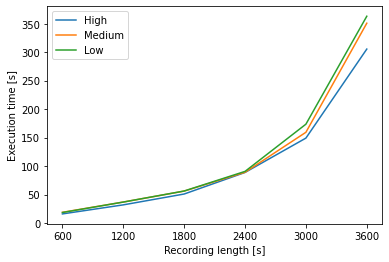

In [61]:
plt.plot(sim_length,df['exec_time'][0:6])
plt.plot(sim_length,df['exec_time'][12:18])
plt.plot(sim_length,df['exec_time'][6:12])
plt.xlabel('Recording length [s]')
plt.ylabel('Execution time [s]')
plt.legend(['High','Medium','Low'])
plt.xticks(sim_length)
plt.show()

In [57]:
def plot_metric_over_time(sim_length,df,metric,ylabel):
    metric_inh = metric + '_inh'
    metric_exc = metric + '_exc'
    
    plt.plot(sim_length,df[metric_exc][0:6],'r',label="High E")
    plt.plot(sim_length,df[metric_inh][0:6],'r--',label="High I")
    plt.plot(sim_length,df[metric_exc][12:18],'b',label="Med E")
    plt.plot(sim_length,df[metric_inh][12:18],'b--',label="Med I")
    plt.plot(sim_length,df[metric_exc][6:12],'g',label="Low E")
    plt.plot(sim_length,df[metric_inh][6:12],'g--',label="Low I")
    plt.xlabel('Recording length [s]')
    plt.ylabel(ylabel)
    plt.legend()
    plt.xticks(sim_length)
    plt.show()

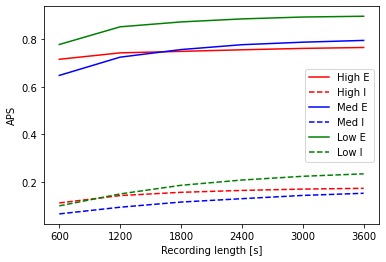

In [58]:
plot_metric_over_time(sim_length,df,'aps','APS')

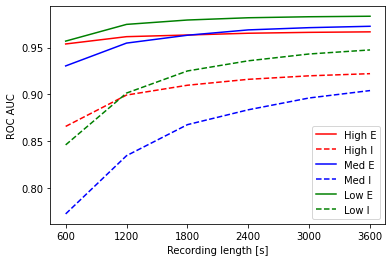

In [59]:
plot_metric_over_time(sim_length,df,'roc_auc','ROC AUC')

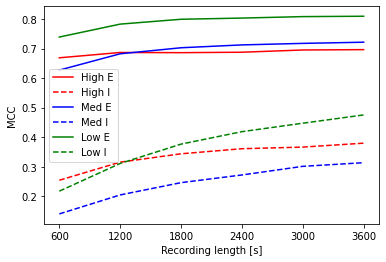

In [60]:
plot_metric_over_time(sim_length,df,'mcc','MCC')

In [67]:
df

,roc_auc_full,roc_auc_exc,roc_auc_inh,aps_full,aps_exc,aps_inh,mcc_full,mcc_exc,mcc_inh,exec_time
h600,0.850646,0.953879,0.865694,0.292591,0.715663,0.111436,0.356130,0.668788,0.254008,15.975392
h1200,0.887442,0.961686,0.899236,0.320971,0.742641,0.142550,0.388956,0.686783,0.315295,31.867434
h1800,0.899946,0.963456,0.909729,0.331100,0.748920,0.156156,0.407159,0.686182,0.343587,50.913867
h2400,0.907855,0.965352,0.916058,0.337786,0.755571,0.164102,0.413717,0.687677,0.360797,88.775412
h3000,0.912568,0.966297,0.919809,0.342913,0.761442,0.169712,0.421107,0.695237,0.366268,149.092152
h3600,0.914852,0.966837,0.922107,0.345980,0.765274,0.172955,0.425501,0.696462,0.379605,305.370665
m600,0.827540,0.956929,0.845931,0.309623,0.777881,0.099262,0.382145,0.739052,0.216971,18.438164
m1200,0.891274,0.974827,0.901366,0.369559,0.852227,0.149392,0.447503,0.782897,0.310910,36.793355
m1800,0.919525,0.979493,0.924999,0.400382,0.872772,0.185714,0.484291,0.799322,0.376369,56.201127
m2400,0.933522,0.981917,0.935862,0.418460,0.885498,0.207778,0.509165,0.803369,0.418578,90.635312


Text(0.5, 0, 'Rec length [s]')

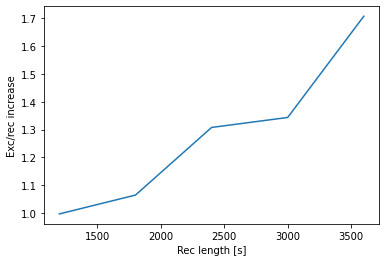

In [84]:
ts = np.linspace(600,3600,6)
rec_ratio = ts[1:]/ts[:-1]
exc_time = np.array(df['exec_time'])
exc_ratio = exc_time[1:6]/exc_time[0:5]
exc_rec = exc_ratio/rec_ratio
plt.plot(ts[1:],exc_rec)
plt.ylabel('Exc/rec increase')
plt.xlabel('Rec length [s]')

In [38]:
metrics_dict.keys()

dict_keys(['roc_auc_full', 'roc_auc_exc', 'roc_auc_inh', 'aps_full', 'aps_exc', 'aps_inh', 'mcc_full', 'mcc_exc', 'mcc_inh', 'exec_time'])

In [4]:
# load gt results
spycon_test = load_test(name, path="../data/gt_data/")

In [9]:
# get neotrains
neo_t = SpikeTrainList.from_spike_time_array(spycon_test.times,spycon_test.ids,np.unique(spycon_test.ids),units='s',t_stop = np.max(spycon_test.times))

# get smoothed data
smoothed = instantaneous_rate(neo_t, sampling_period=1*pq.ms, kernel=GaussianKernel(3*pq.ms))

In [11]:
np_array = np.array(smoothed).T
DDC = compute_DDC(np_array)

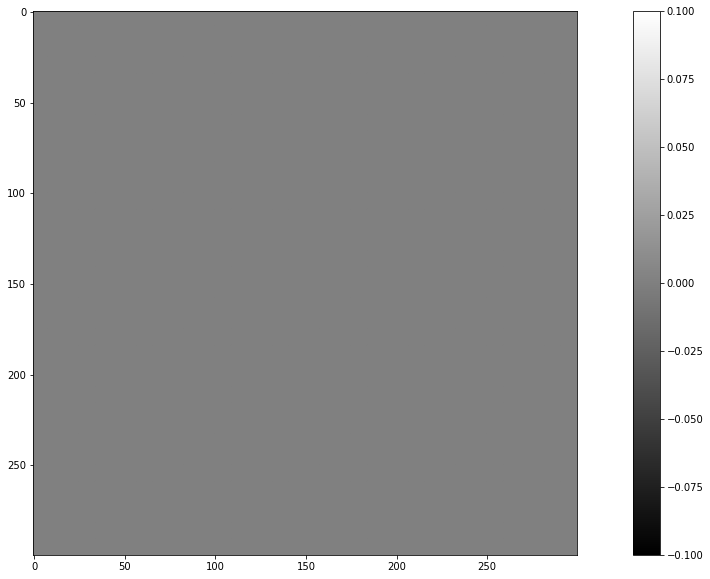

In [41]:
plt.rcParams["figure.figsize"]=20,10
fig, ax = plt.subplots()
im = ax.imshow(DDC==0,cmap="gray")
cbar = ax.figure.colorbar(im, ax=ax)

In [33]:
true_con = spycon_test.create_connectivity_matrix()

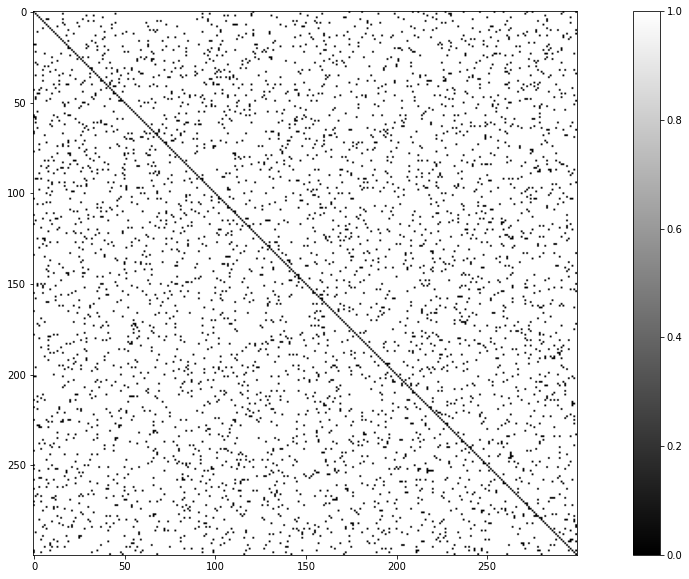

In [48]:
plt.rcParams["figure.figsize"]=20,10
fig, ax = plt.subplots()
im = ax.imshow(true_con==0,cmap="gray")
cbar = ax.figure.colorbar(im, ax=ax)

In [54]:
roc_auc = metrics.roc_auc_score(spycon_test.create_connectivity_matrix()!=0, np.abs(DDC))

In [55]:
bin_con = true_con!=0

In [59]:
fpr,tpr,th = metrics.roc_curve(np.ravel(bin_con*1), np.ravel(np.abs(DDC)),pos_label=1)

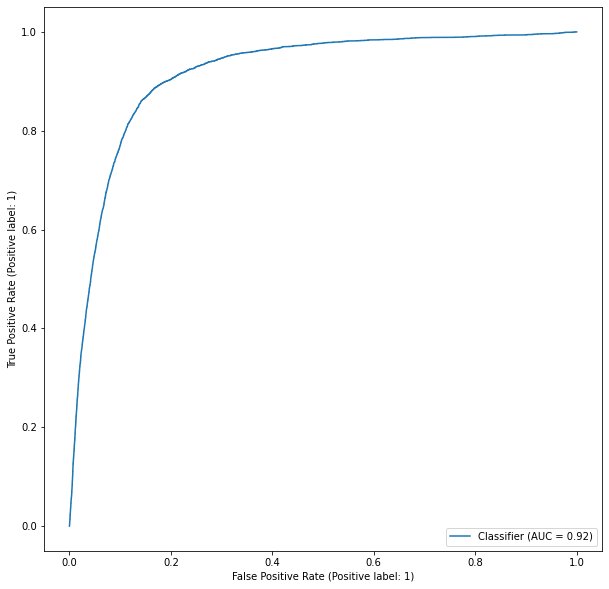

In [61]:
plt.rcParams["figure.figsize"]=10,10
metrics.RocCurveDisplay.from_predictions(np.ravel(bin_con*1), np.ravel(np.abs(DDC)),pos_label=1)

In [96]:
true_con = spycon_test.create_connectivity_matrix()
true_con[true_con>0] = 1
true_con[true_con<0] = -1
#true_con[np.diag_indices_from(true_con)] = 0

In [104]:
true_flat = np.ravel(true_con)
true_flat = np.delete(true_flat,np.argwhere(np.isnan(true_flat)))

In [265]:
full_con = np.int32(true_flat!=0)
exc_con = np.int32(true_flat==1)
inh_con = np.int32(true_flat==-1)

In [119]:
np.fill_diagonal(DDC,np.nan)
DDC_flat = np.ravel(-DDC)
DDC_flat = np.delete(DDC_flat,np.argwhere(np.isnan(DDC_flat)))

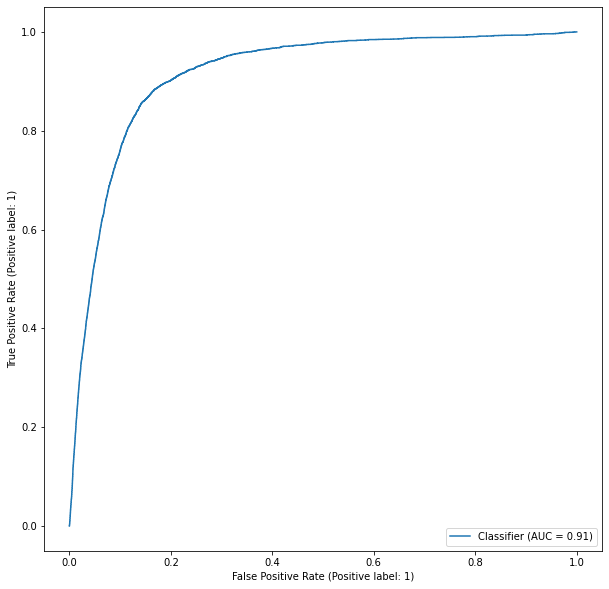

In [122]:
metrics.RocCurveDisplay.from_predictions(np.abs(true_flat), np.abs(DDC_flat), pos_label=1)

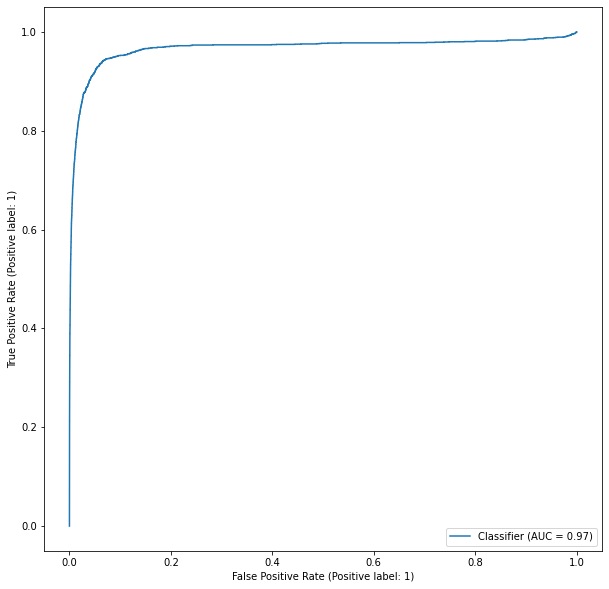

In [227]:
metrics.RocCurveDisplay.from_predictions(exc_con, DDC_flat, pos_label=1)

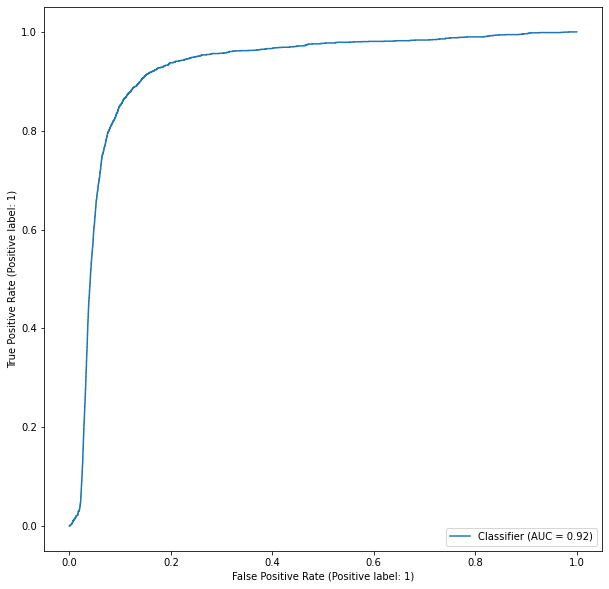

In [262]:
metrics.RocCurveDisplay.from_predictions(inh_con, -DDC_flat, pos_label=1)

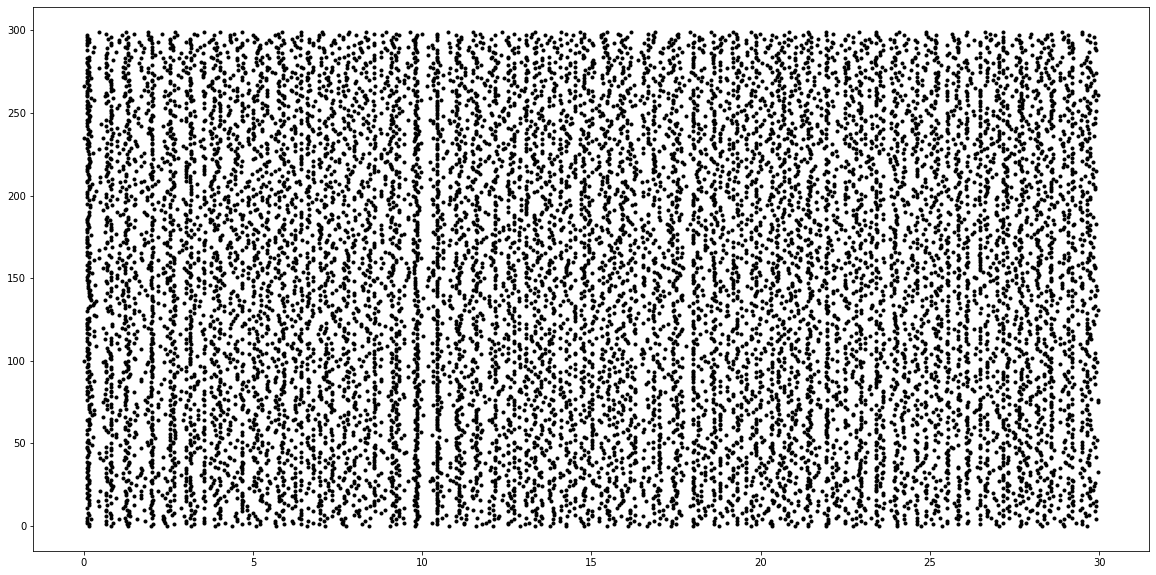

In [126]:
plt.rcParams["figure.figsize"]=20,10
plt.plot(
    spycon_test.times[spycon_test.times < 30],
    spycon_test.ids[spycon_test.times < 30],
    "k.",
)
plt.show()


In [128]:
metrics.average_precision_score(exc_con, DDC_flat, pos_label=1)

0.76527378508013

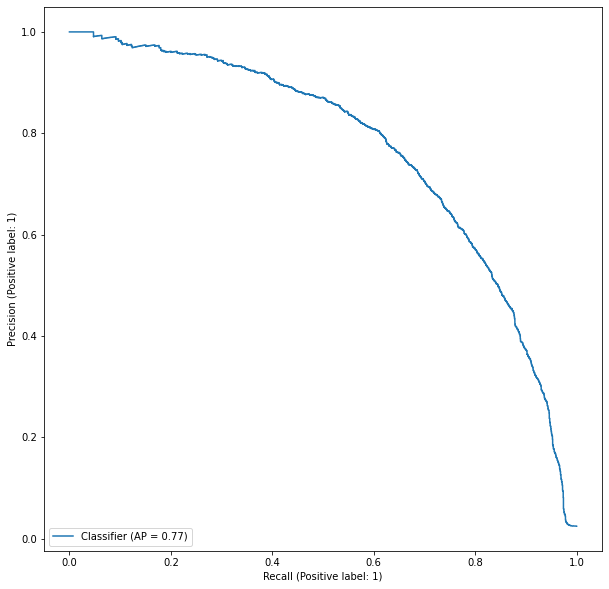

In [189]:
plt.rcParams["figure.figsize"]=10,10
metrics.PrecisionRecallDisplay.from_predictions(exc_con, DDC_flat)

In [131]:
metrics.average_precision_score(inh_con, DDC_flat, pos_label=0)

0.9974493421719951

In [276]:
np.unique(exc_con)

array([0, 1])

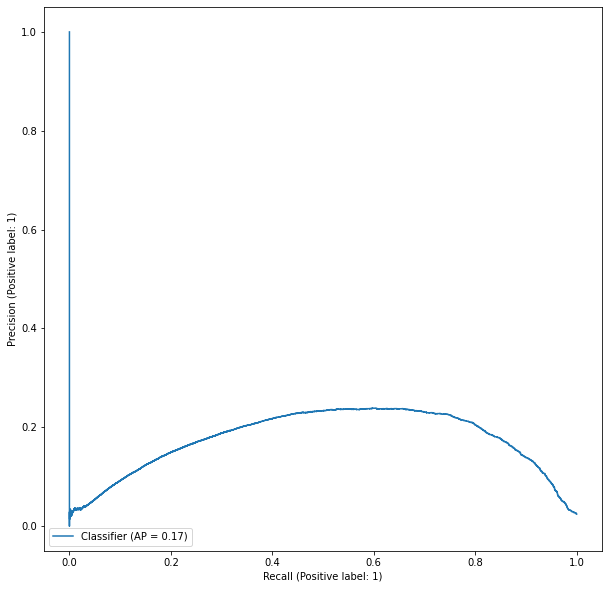

In [277]:
metrics.PrecisionRecallDisplay.from_predictions(inh_con, -DDC_flat)

In [85]:
np.save('DDC.npy',DDC)

In [86]:
np.save('smooth_fr.npy',ddc_input)